# Extract blue lines

Mainly Hβ, He II, He I, [O III], [Ar IV], [N I], Si II

## Library imports and data loading

Copied from the `02-01-Raman-Wings-IR-Source-C` notebook:

In [1]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from mpdaf.obj import Cube
import regions
import sys
sys.path.append("../lib")
import moments
import extract

sns.set_context("talk")
sns.set_color_codes()

In [2]:
moments.FIGPATH = Path("../figs")
moments.SAVEPATH = Path("../data")

Load the co-added datacube (cube1) and the good-seeing one (cube2).

In [3]:
datapath = Path("/Users/will/Work/Muse-Hii-Data/SMC-NGC-346/")
file1 = "ADP.2017-10-16T11_04_19.247.fits"
file2 = "ADP.2016-10-12T05_43_23.882.fits"
cube1 = Cube(str(datapath / file1))
cube2 = Cube(str(datapath / file2))

## Use moments to extract the Hβ line and other blue lines

Use a generic name for the cube over the broad wavelength range to reduce need for edits when we repurpose this later.

In [4]:
wavmin, wavmax = 4600, 5400

We mainly work with the good seeing cube, but also use the summed one (mcube). 

In [5]:
cube = cube2.select_lambda(wavmin, wavmax)
mcube = cube1.select_lambda(wavmin, wavmax)

In [6]:
# Position of mYSO
x, y = 116, 147
# position of B0 star SSN 43
xb, yb = 95, 163
# position of B0 star SSN 40
xbb, ybb = 121, 133
m = 3

boxes = {
    "SSN 152+168": regions.BoundingBox(
        iymin=y-m, iymax=y+m, ixmin=x-m, ixmax=x+m,
    ),
#    "BG 152+168": regions.BoundingBox(
#        iymin=y-2*m, iymax=y+2*m, ixmin=x-2*m, ixmax=x+2*m,
#    ),
    "SSN 43": regions.BoundingBox(
        iymin=yb-m, iymax=yb+m, ixmin=xb-m, ixmax=xb+m,
    ),
#    "BG 43": regions.BoundingBox(
#        iymin=yb-2*m, iymax=yb+2*m, ixmin=xb-2*m, ixmax=xb+2*m,
#    ),
    "SSN 40": regions.BoundingBox(
        iymin=ybb-m, iymax=ybb+m, ixmin=xbb-m, ixmax=xbb+m,
    ),
#    "BG 40": regions.BoundingBox(
#        iymin=ybb-2*m, iymax=ybb+2*m, ixmin=xbb-2*m, ixmax=xbb+2*m,
#    ),
    "blue": regions.BoundingBox(
        iymin=75, iymax=140, ixmin=15, ixmax=40
    ),
    "red": regions.BoundingBox(
        iymin=200, iymax=250, ixmin=210, ixmax=300
    ),
    "magenta": regions.BoundingBox(
        iymin=10, iymax=50, ixmin=100, ixmax=150
    ),
    "green": regions.BoundingBox(
        iymin=10, iymax=100, ixmin=200, ixmax=300
    ),
    "cyan": regions.BoundingBox(
        iymin=170, iymax=210, ixmin=90, ixmax=120
    ),
}


These are the ranges that the continum is fitted to. It is OK if they contain some weak lines.

In [7]:
wavranges = [
    (4600, 4620), (4720, 4730), (4760, 4800),
    (4937, 4947), (4974, 4984), (5028, 5038), (5070, 5100), 
    (5120, 5145), (5220, 5260), (5330, 5390),
]

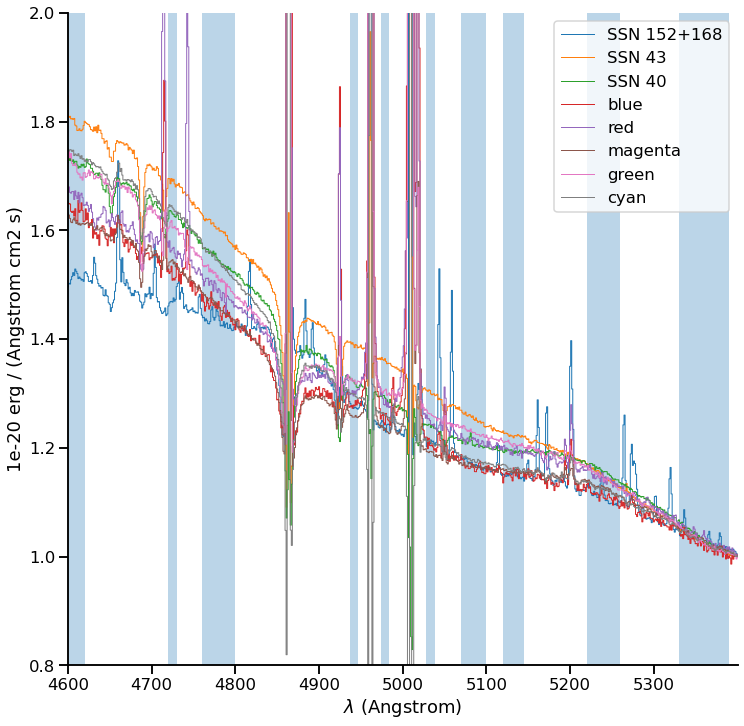

In [8]:
fig, ax = plt.subplots(figsize=(12, 12))
for label, box in boxes.items():
    yslice, xslice = box.slices
    spec = cube[:, yslice, xslice].mean(axis=(1, 2))
    (spec / spec.data[-1]).plot(label=label)
    
for wavrange in wavranges:
    ax.axvspan(*wavrange, alpha=0.3)
ax.legend()
ax.set(
    ylim=[0.8, 2.0],
)
sns.despine();

In [9]:
yslice, xslice = boxes["SSN 152+168"].slices
subcube = cube[:, yslice, xslice]
contcube = extract.fit_continuum(
    subcube, wav_ranges=wavranges, deg=6, median=False,
)

extract.fit_continuum: row 0


[(4000.0, 8000.0)]

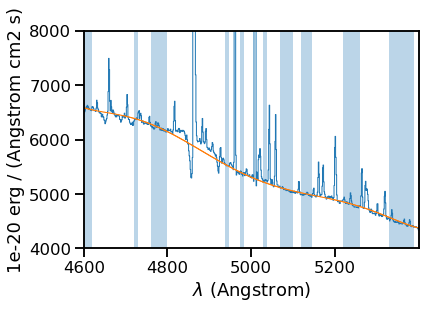

In [10]:
fig, ax = plt.subplots()
subcube.mean(axis=(1, 2)).plot()
contcube.mean(axis=(1, 2)).plot()
for wavrange in wavranges:
    ax.axvspan(*wavrange, alpha=0.3)
ax.set(ylim=[4000, 8000])

In [11]:
yslice, xslice = boxes["green"].slices
subcube = mcube[:, yslice, xslice]
contcube = extract.fit_continuum(
    subcube, wav_ranges=wavranges, deg=6, median=False,
)

extract.fit_continuum: row 0
extract.fit_continuum: row 10
extract.fit_continuum: row 20
extract.fit_continuum: row 30
extract.fit_continuum: row 40
extract.fit_continuum: row 50
extract.fit_continuum: row 60
extract.fit_continuum: row 70
extract.fit_continuum: row 80


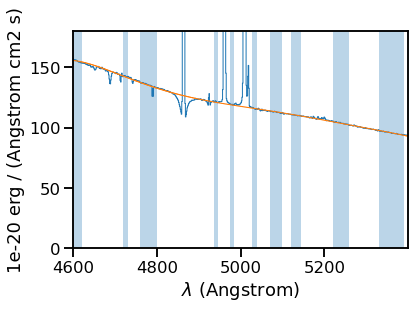

In [12]:
fig, ax = plt.subplots()
subcube.mean(axis=(1, 2)).plot()
contcube.mean(axis=(1, 2)).plot()
for wavrange in wavranges:
    ax.axvspan(*wavrange, alpha=0.3)
ax.set(ylim=[0, 180]);

So it turns out that a high order polynomial is needed because of the broad wavelength range.  And it is better to use the full set of points rather than the median *and* that is faster too!

Calculating the median must be expensive.

In [13]:
contcube = extract.fit_continuum(
    cube, wav_ranges=wavranges, deg=6, median=False,
)

extract.fit_continuum: row 0


/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/polynomial/polyutils.py:345: RuntimeWarning: divide by zero encountered in double_scalars
  off = (old[1]*new[0] - old[0]*new[1])/oldlen
/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/polynomial/polyutils.py:346: RuntimeWarning: divide by zero encountered in true_divide
  scl = newlen/oldlen
/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/polynomial/polyutils.py:414: RuntimeWarning: invalid value encountered in add
  return off + scl*x


extract.fit_continuum: row 10
extract.fit_continuum: row 20
extract.fit_continuum: row 30
extract.fit_continuum: row 40
extract.fit_continuum: row 50
extract.fit_continuum: row 60
extract.fit_continuum: row 70
extract.fit_continuum: row 80
extract.fit_continuum: row 90
extract.fit_continuum: row 100


/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py:1673: RankWarning: The fit may be poorly conditioned
  return pu._fit(chebvander, x, y, deg, rcond, full, w)


extract.fit_continuum: row 110
extract.fit_continuum: row 120
extract.fit_continuum: row 130
extract.fit_continuum: row 140
extract.fit_continuum: row 150
extract.fit_continuum: row 160
extract.fit_continuum: row 170
extract.fit_continuum: row 180
extract.fit_continuum: row 190
extract.fit_continuum: row 200
extract.fit_continuum: row 210
extract.fit_continuum: row 220
extract.fit_continuum: row 230
extract.fit_continuum: row 240
extract.fit_continuum: row 250
extract.fit_continuum: row 260
extract.fit_continuum: row 270
extract.fit_continuum: row 280
extract.fit_continuum: row 290
extract.fit_continuum: row 300
extract.fit_continuum: row 310
extract.fit_continuum: row 320


In [14]:
mcontcube = extract.fit_continuum(
    mcube, wav_ranges=wavranges, deg=6, median=False,
)

extract.fit_continuum: row 0


/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py:1673: RankWarning: The fit may be poorly conditioned
  return pu._fit(chebvander, x, y, deg, rcond, full, w)


extract.fit_continuum: row 10
extract.fit_continuum: row 20
extract.fit_continuum: row 30
extract.fit_continuum: row 40
extract.fit_continuum: row 50
extract.fit_continuum: row 60
extract.fit_continuum: row 70
extract.fit_continuum: row 80
extract.fit_continuum: row 90
extract.fit_continuum: row 100
extract.fit_continuum: row 110


/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/polynomial/polyutils.py:345: RuntimeWarning: divide by zero encountered in double_scalars
  off = (old[1]*new[0] - old[0]*new[1])/oldlen
/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/polynomial/polyutils.py:346: RuntimeWarning: divide by zero encountered in true_divide
  scl = newlen/oldlen
/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/polynomial/polyutils.py:414: RuntimeWarning: invalid value encountered in add
  return off + scl*x


extract.fit_continuum: row 120
extract.fit_continuum: row 130
extract.fit_continuum: row 140
extract.fit_continuum: row 150
extract.fit_continuum: row 160
extract.fit_continuum: row 170
extract.fit_continuum: row 180
extract.fit_continuum: row 190
extract.fit_continuum: row 200
extract.fit_continuum: row 210
extract.fit_continuum: row 220
extract.fit_continuum: row 230
extract.fit_continuum: row 240
extract.fit_continuum: row 250
extract.fit_continuum: row 260
extract.fit_continuum: row 270
extract.fit_continuum: row 280
extract.fit_continuum: row 290
extract.fit_continuum: row 300
extract.fit_continuum: row 310
extract.fit_continuum: row 320


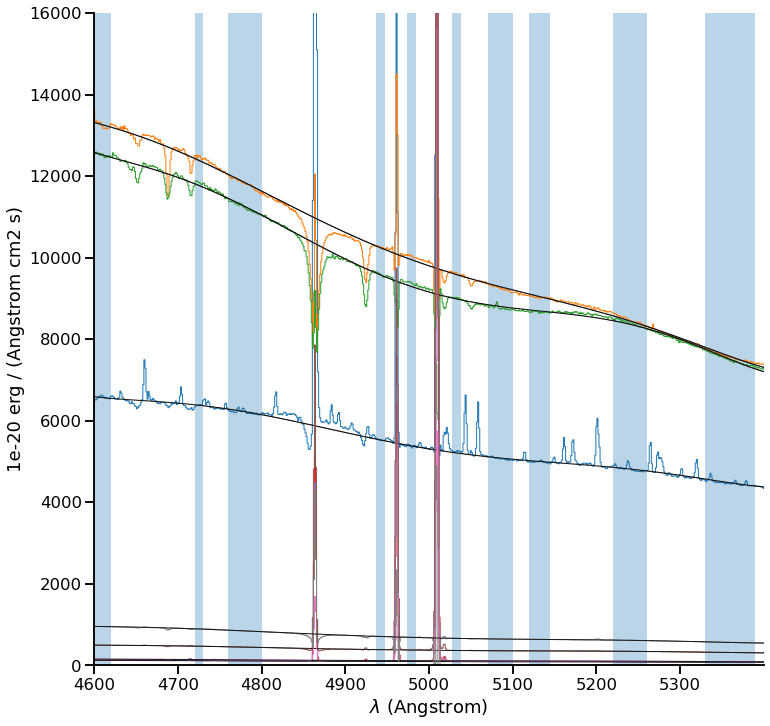

In [15]:
fig, ax = plt.subplots(figsize=(12, 12))
for box in boxes.values():
    yslice, xslice = box.slices
    spec = cube[:, yslice, xslice].mean(axis=(1, 2))
    cspec = contcube[:, yslice, xslice].mean(axis=(1, 2))
    spec.plot()
    cspec.plot(color="k")
    
for wavrange in wavranges:
    ax.axvspan(*wavrange, alpha=0.3)
ax.set(
    ylim=[0, 16000],
)
sns.despine();

In [16]:
prefix = f"../big-data/ngc346-sharp-{wavmin:d}-{wavmax:d}-cube"
prefix

'../big-data/ngc346-sharp-4600-5400-cube'

In [17]:
csubcube = (cube - contcube)
cdivcube = (cube / contcube)

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/mpdaf/obj/arithmetic.py:124: RuntimeWarning: invalid value encountered in true_divide
  var /= (b_data ** 4)


In [18]:
csubcube.write(
    f"{prefix}-contsub.fits",
    savemask="nan",
    )
cdivcube.write(
    f"{prefix}-contdiv.fits",
    savemask="nan",
    )
contcube.write(
    f"{prefix}-cont.fits",
    savemask="nan",
    )

In [19]:
mprefix = f"../big-data/ngc346-{wavmin:d}-{wavmax:d}-cube"
mprefix

'../big-data/ngc346-4600-5400-cube'

In [20]:
mcsubcube = (mcube - mcontcube)
mcdivcube = (mcube / mcontcube)

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/mpdaf/obj/arithmetic.py:124: RuntimeWarning: invalid value encountered in true_divide
  var /= (b_data ** 4)


In [21]:
mcsubcube.write(
    f"{mprefix}-contsub.fits",
    savemask="nan",
    )
mcdivcube.write(
    f"{mprefix}-contdiv.fits",
    savemask="nan",
    )
mcontcube.write(
    f"{mprefix}-cont.fits",
    savemask="nan",
    )

## Extract He II line

In [53]:
mom4686 = moments.find_moments(
    mcsubcube.select_lambda(4686, 4691)
)

../lib/moments.py:41: RuntimeWarning: invalid value encountered in sqrt
  mom2.data = np.sqrt(mom2.data)


In [54]:
dlam, _, _ = cube.get_step()
cont4686 = mcontcube.select_lambda(4686, 4691).mean(axis=0)
ew4686 = (
    dlam * mom4686[0] / cont4686 
)

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/mpdaf/obj/arithmetic.py:124: RuntimeWarning: invalid value encountered in true_divide
  var /= (b_data ** 4)


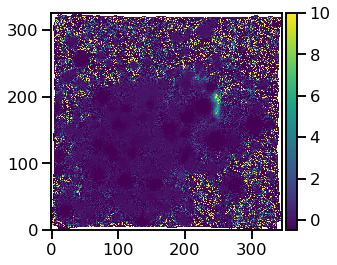

In [55]:
ew4686.plot(vmin=-0.5, vmax=10, colorbar="v")

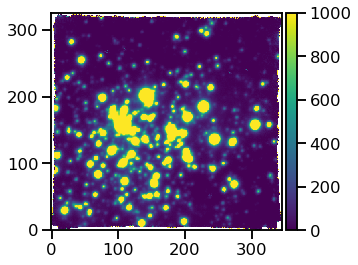

In [56]:
cont4686.plot(vmin=0, vmax=1000, colorbar="v")

In [57]:
mom4686[0].mask = mom4686[0].mask | (cont4686.data > 1000)

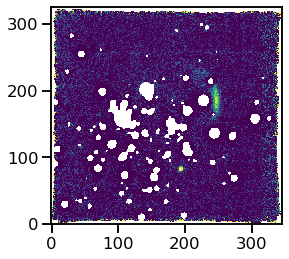

In [58]:
mom4686[0].rebin(1).plot(vmin=0, vmax=300)

In [59]:
mom_pars_4686 = dict(
    restwav=4685.68,
    irange=[-10, 1000],
    vrange=[-250, 550],
    srange=[0, 600],    
)

../lib/moments.py:117: RuntimeWarning: invalid value encountered in log10
  f"log10 I({label})": np.log10(mom0.data[~m]),
../lib/moments.py:125: RuntimeWarning: invalid value encountered in log10
  f"log10 I({label})": np.log10(irange),


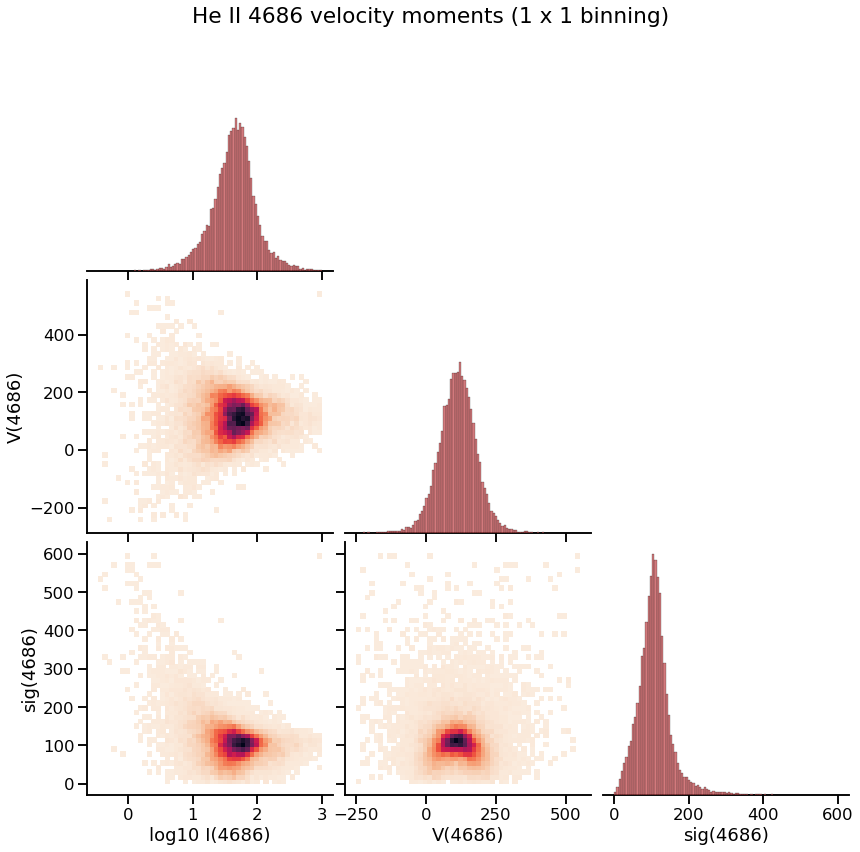

In [60]:
plot_pars_4686=dict(
    ilabel="He II",
    label="4686",
    flabel="ngc346-heii",
    **mom_pars_4686,
)
g = moments.moments_corner_plot(
    mom4686, rebin=1, **plot_pars_4686,
)

../lib/moments.py:117: RuntimeWarning: invalid value encountered in log10
  f"log10 I({label})": np.log10(mom0.data[~m]),
../lib/moments.py:125: RuntimeWarning: invalid value encountered in log10
  f"log10 I({label})": np.log10(irange),


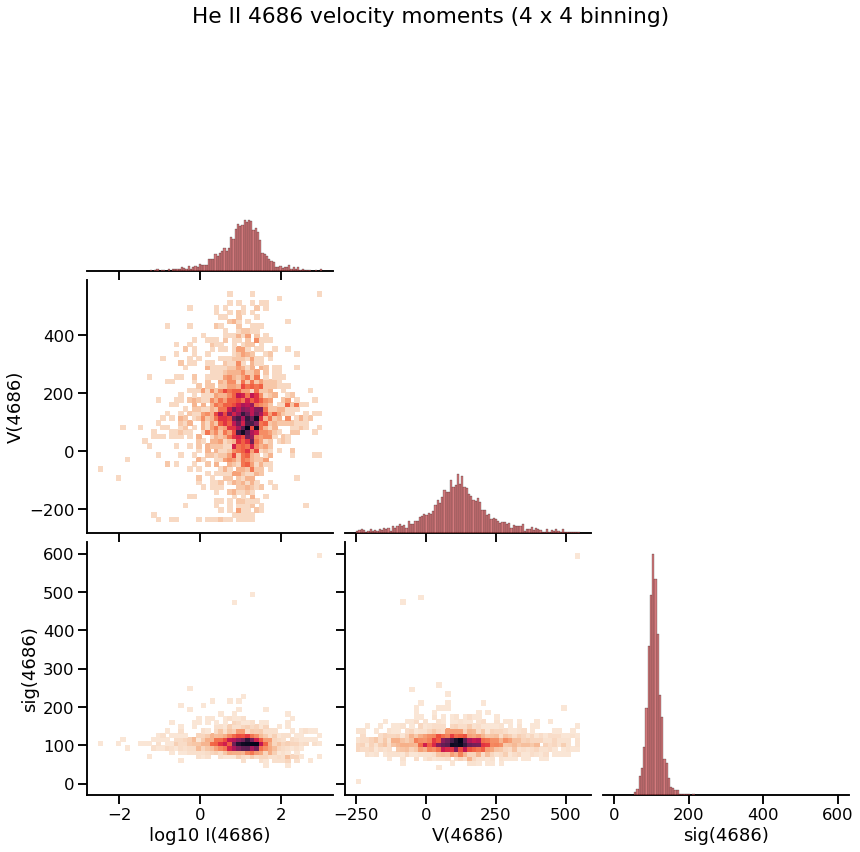

In [61]:
g = moments.moments_corner_plot(
    mom4686, rebin=4, **plot_pars_4686,
)

../lib/moments.py:125: RuntimeWarning: invalid value encountered in log10
  f"log10 I({label})": np.log10(irange),


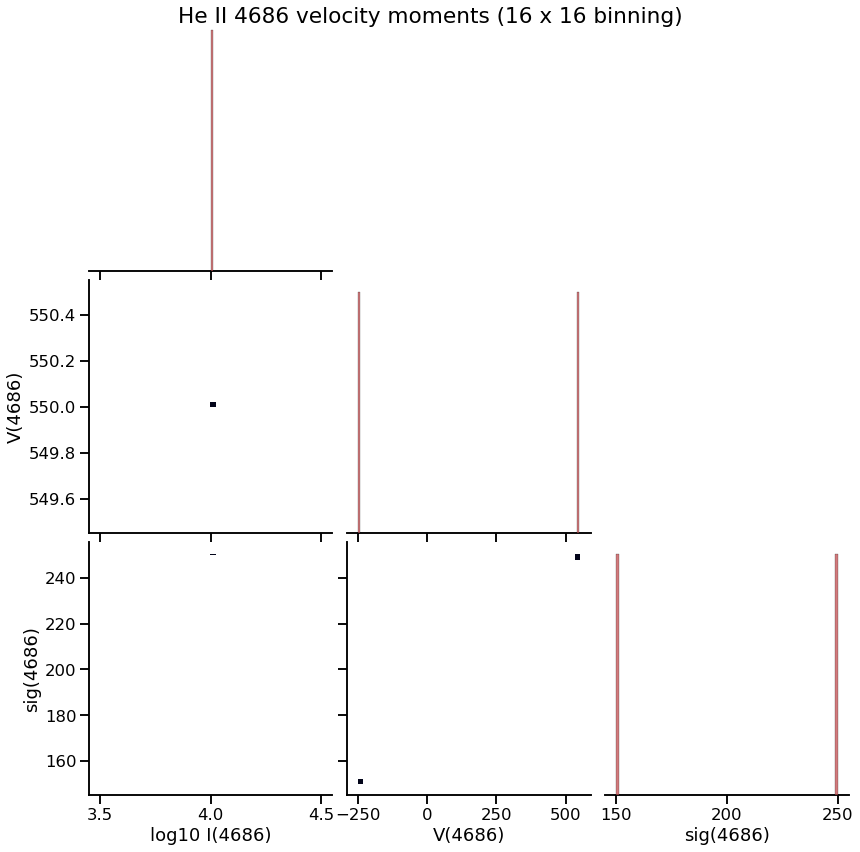

In [62]:
mom_pars_4686 = dict(
    restwav=4685.68,
    irange=[-1000, 1e4],
    vrange=[-250, 550],
    srange=[150, 250],    
)
plot_pars_4686=dict(
    ilabel="He II",
    label="4686",
    flabel="ngc346-heii",
    **mom_pars_4686,
)
g = moments.moments_corner_plot(
    mom4686, rebin=16, **plot_pars_4686,
)

Unfortunately, the velocity spread does not decrease with binning, although the sigma spread does.

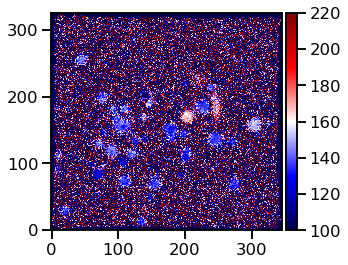

In [63]:
(3e5*(mom4686[1] / 4685.68 - 1.0)).rebin(1).plot(
    vmin=100, vmax=220, 
    cmap="seismic", 
    colorbar="v",
)

In [64]:
map4686 = mom4686[0].copy()
map4686.mask = map4686.mask | (map4686.data < -100)

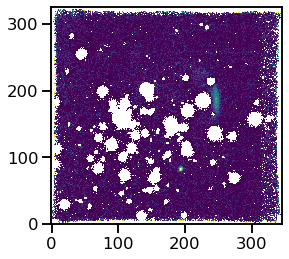

In [65]:
map4686.rebin(1).plot(
    vmin=0, vmax=500,
)

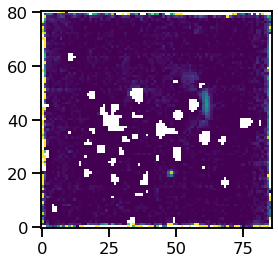

In [66]:
map4686.rebin(4).plot(
    vmin=0, vmax=500,
)

In [67]:
mom_pars_4686 = dict(
    restwav=4685.68,
    irange=None,
    vrange=None,
    srange=None,    
)
moments.save_moments_to_fits(
    mom4686,
    label="4686",
    flabel="ngc346-heii",
    **mom_pars_4686,
)

## Extract [Ar IV] line

In [49]:
mom4740 = moments.find_moments(
    mcsubcube.select_lambda(4740, 4746)
)

../lib/moments.py:41: RuntimeWarning: invalid value encountered in sqrt
  mom2.data = np.sqrt(mom2.data)


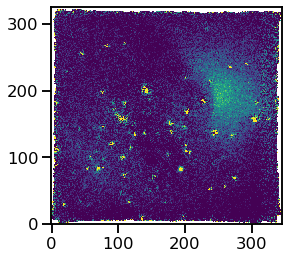

In [50]:
mom4740[0].plot(vmin=0.0, vmax=300.0)

In [51]:
mom_pars_4740 = dict(
    restwav=4740.17,
    irange=[-10, 1000],
    vrange=[-250, 550],
    srange=[0, 600],    
)

../lib/moments.py:117: RuntimeWarning: invalid value encountered in log10
  f"log10 I({label})": np.log10(mom0.data[~m]),
../lib/moments.py:125: RuntimeWarning: invalid value encountered in log10
  f"log10 I({label})": np.log10(irange),


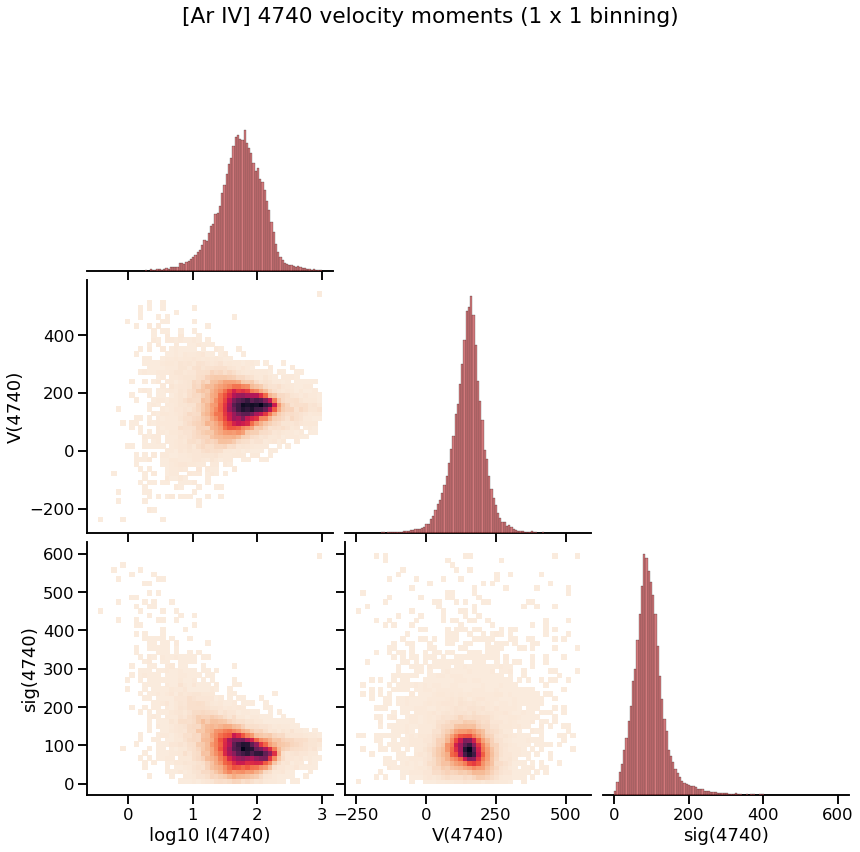

In [52]:
plot_pars_4740=dict(
    ilabel="[Ar IV]",
    label="4740",
    flabel="ngc346-ariv",
    **mom_pars_4740,
)
g = moments.moments_corner_plot(
    mom4740, rebin=1, **plot_pars_4740,
)

In [68]:
moments.save_moments_to_fits(
    mom4740,
    label="4740",
    flabel="ngc346-ariv",
    restwav=4740.17,
)

NameError: name 'mom6300' is not defined

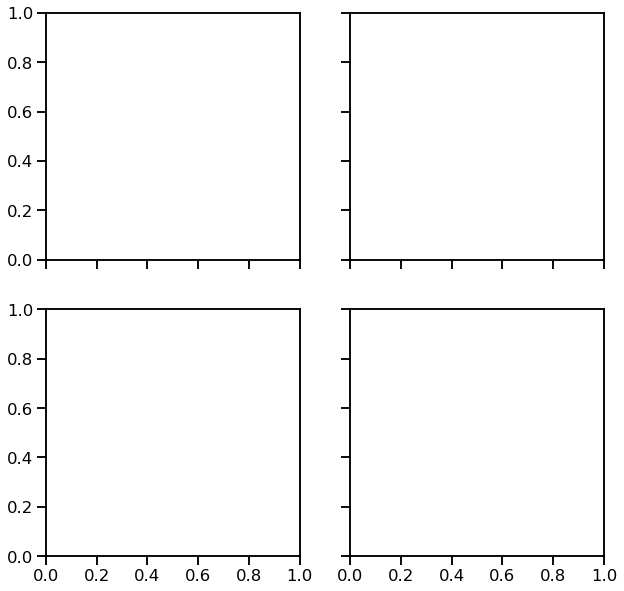

In [38]:
fig, axes = plt.subplots(
    2, 2, 
    figsize=(10, 10),
    sharex=True, sharey=True,
)

imap = mom6300[0].copy()
vmap = 3e5*(mom6300[1] / 6300.30 - 1.0)
smap = 3e5*(mom6300[2] / 6300.30)

m = imap.data > 10.

vmap.mask = vmap.mask | (~m)
smap.mask = smap.mask | (~m)

imap.rebin(1).plot(
    vmin=-500, vmax=3e4, 
    cmap="turbo", 
    ax=axes[0, 0],
)

vmap.rebin(1).plot(
    vmin=100, vmax=220, 
    cmap="seismic", 
    ax=axes[0, 1],
)

smap.rebin(1).plot(
    vmin=0, vmax=120, 
    cmap="magma", 
    ax=axes[1, 0],
)

imap.rebin(1).plot(
    vmin=-350, vmax=-200, 
    cmap="viridis", 
    ax=axes[1, 1],
)
bg_6300 = contcube.select_lambda(w1, w2).mean(axis=0)
axes[1, 1].contour(
    bg_6300.data,
    levels=[300],
    colors="r",
)

fig.tight_layout();

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
for box in boxes.values():
    yslice, xslice = box.slices
    spec = wide_6300[:, yslice, xslice].mean(axis=(1, 2))
    (spec / spec.data.max()).plot()
    
sns.despine();

In [ ]:
msky = (imap.data < -100) & (imap.data > -200) & (bg_6300.data < 300)
msky[310:, :] = False
msky[:, 310:] = False
msky[:10, :] = False
msky[:, :10] = False

In [ ]:
msky.sum(), np.where(msky)

In [ ]:
core_6300 = wide_6300.select_lambda(w1, w2)
sky_6300 = core_6300.copy() 
sky_6300.mask = sky_6300.mask | ~msky[None, : :]

In [ ]:
sky_6300.mean(axis=(1, 2)).plot()

In [ ]:
corr_6300 = core_6300 - sky_6300.mean(axis=(1, 2))

In [ ]:
testpixels = [
    [250, 160], [150, 150], [160, 220],
    [70, 250], [75, 200], [310, 225],
    [25, 140], [250, 250], [140, 110], #[180, 290],
]
fig, axes = plt.subplots(
    3, 3, 
    figsize=(10, 8), 
    sharex=True,
    sharey="row",
)
for (j, i), ax in zip(testpixels, axes.flat):
    core_6300[:, j, i].plot(ax=ax)
    corr_6300[:, j, i].plot(ax=ax) 
    ax.set(xlabel="", ylabel="")
    ax.set_title(f"[{j}, {i}]")
fig.suptitle(
    "Before/after sky correction for faint/moderate/bright pixels"
)
sns.despine()
fig.tight_layout();

In [ ]:
mom6300c = moments.find_moments(corr_6300)

In [ ]:
g = moments.moments_corner_plot(
    mom6300c, rebin=1, **plot_pars_6300
)

In [ ]:
g = moments.moments_corner_plot(
    mom6300c, rebin=4, **plot_pars_6300
)

In [ ]:
fig, axes = plt.subplots(
    2, 2, 
    figsize=(10, 10),
    sharex=True, sharey=True,
)

imap = mom6300c[0].copy()
vmap = 3e5*(mom6300c[1] / 6300.30 - 1.0)
smap = 3e5*(mom6300c[2] / 6300.30)

m = imap.data > 0.

vmap.mask = vmap.mask | (~m)
smap.mask = smap.mask | (~m)

vmap_old = 3e5*(mom6300[1] / 6300.30 - 1.0)
vmap_old.mask = vmap_old.mask | (~m)


imap.rebin(1).plot(
    vmin=0, vmax=1e4, 
    cmap="turbo", 
    ax=axes[0, 0],
)

vmap.rebin(1).plot(
    vmin=120, vmax=180, 
    cmap="seismic", 
    ax=axes[0, 1],
)

smap.rebin(1).plot(
    vmin=40, vmax=120, 
    cmap="magma", 
    ax=axes[1, 0],
)

vmap_old.rebin(1).plot(
    vmin=120, vmax=180, 
    cmap="seismic", 
    ax=axes[1, 1],
)


fig.tight_layout();

In [ ]:
vmap.rebin(4).plot(
    vmin=120, vmax=180, 
    cmap="seismic", 
)

In [ ]:
g = moments.moments_corner_plot(
    mom6300c, rebin=8, **plot_pars_6300,
    hist_bins=40,
    image_bins=20,    
);

There is clearly a problem still with the fainter pixels.  Witness the trend of sig with intensity.  But theis is not so important for studying the brighter parts.

In [ ]:
mom_pars_6300 = dict(
    restwav=6300.30,
    irange=[-150, 4.0e4],
    vrange=[85, 255],
    srange=[30, 150],    
)
moments.save_moments_to_fits(
    mom6300c,
    label="6300",
    flabel="ngc346-sharp-oi",
    **mom_pars_6300,
)

In [ ]:
wide_6300.wave.coord()

In [ ]:
core_6363 = (oi6300cube - contcube).select_lambda(6362, 6372)
mom6363 = moments.find_moments(core_6363)

In [ ]:
mom_pars_6363 = dict(
    restwav=6363.78,
    irange=[-50, 1.3e4],
    vrange=[85, 255],
    srange=[30, 150],    
)

In [ ]:
plot_pars_6363=dict(
    ilabel="O I",
    label="6363",
    flabel="ngc346-oi",
    **mom_pars_6363,
)
g = moments.moments_corner_plot(
    mom6363, rebin=1, **plot_pars_6363,
)

In [ ]:
g = moments.moments_corner_plot(
    mom6363, rebin=4, **plot_pars_6363,
)

In [ ]:
(3e5*(mom6363[1] / 6363.78 - 1.0)).rebin(1).plot(
    vmin=100, vmax=220, 
    cmap="seismic", 
    colorbar="v",
)

In [ ]:
fig, axes = plt.subplots(
    2, 2, 
    figsize=(10, 10),
    sharex=True, sharey=True,
)

imap = mom6363[0].copy()
vmap = 3e5*(mom6363[1] / 6363.78 - 1.0)
smap = 3e5*(mom6363[2] / 6363.78)

m = imap.data > 10.

vmap.mask = vmap.mask | (~m)
smap.mask = smap.mask | (~m)

imap.rebin(1).plot(
    vmin=-500/3, vmax=3e4/3, 
    cmap="turbo", 
    ax=axes[0, 0],
)

vmap.rebin(1).plot(
    vmin=100, vmax=220, 
    cmap="seismic", 
    ax=axes[0, 1],
)

smap.rebin(1).plot(
    vmin=0, vmax=120, 
    cmap="magma", 
    ax=axes[1, 0],
)

imap.rebin(1).plot(
    vmin=-350/3, vmax=-200/3, 
    cmap="viridis", 
    ax=axes[1, 1],
)
bg_6363 = contcube.select_lambda(6362, 6372).mean(axis=0)
axes[1, 1].contour(
    bg_6363.data,
    levels=[300],
    colors="r",
)

fig.tight_layout();

In [ ]:
sky_6363 = core_6363.copy() 
sky_6363.mask = sky_6363.mask | ~msky[None, : :]

In [ ]:
sky_6363.mean(axis=(1, 2)).plot()

In [ ]:
corr_6363 = core_6363 - sky_6363.mean(axis=(1, 2))

In [ ]:
testpixels = [
    [250, 160], [150, 150], [160, 220],
    [70, 250], [75, 200], [310, 225],
    [25, 140], [250, 250], [140, 110], #[180, 290],
]
fig, axes = plt.subplots(
    3, 3, 
    figsize=(10, 8), 
    sharex=True,
    sharey="row",
)
for (j, i), ax in zip(testpixels, axes.flat):
    core_6363[:, j, i].plot(ax=ax)
    corr_6363[:, j, i].plot(ax=ax) 
    ax.set(xlabel="", ylabel="")
    ax.set_title(f"[{j}, {i}]")
fig.suptitle(
    "Before/after sky correction for faint/moderate/bright pixels"
)
sns.despine()
fig.tight_layout();

In [ ]:
mom6363c = moments.find_moments(corr_6363)

In [ ]:
g = moments.moments_corner_plot(
    mom6363c, rebin=1, **plot_pars_6363
)

In [ ]:
g = moments.moments_corner_plot(
    mom6363c, rebin=4, **plot_pars_6363
)

In [ ]:
fig, axes = plt.subplots(
    2, 2, 
    figsize=(10, 10),
    sharex=True, sharey=True,
)

imap = mom6363c[0].copy()
vmap = 3e5*(mom6363c[1] / 6363.78 - 1.0)
smap = 3e5*(mom6363c[2] / 6363.78)

m = imap.data > 0.

vmap.mask = vmap.mask | (~m)
smap.mask = smap.mask | (~m)

vmap_old = 3e5*(mom6363[1] / 6363.78 - 1.0)
vmap_old.mask = vmap_old.mask | (~m)


imap.rebin(1).plot(
    vmin=0, vmax=1e4/3, 
    cmap="turbo", 
    ax=axes[0, 0],
)

vmap.rebin(1).plot(
    vmin=120, vmax=180, 
    cmap="seismic", 
    ax=axes[0, 1],
)

smap.rebin(1).plot(
    vmin=40, vmax=120, 
    cmap="magma", 
    ax=axes[1, 0],
)

vmap_old.rebin(1).plot(
    vmin=120, vmax=180, 
    cmap="seismic", 
    ax=axes[1, 1],
)


fig.tight_layout();

In [ ]:
mom_pars_6363 = dict(
    restwav=6363.78,
    irange=[-150, 1.3e4],
    vrange=[85, 255],
    srange=[30, 150],    
)
moments.save_moments_to_fits(
    mom6363c,
    label="6363",
    flabel="ngc346-sharp-oi",
    **mom_pars_6363,
)

## Other lines in the wav range: [S III] and Si II

In [ ]:
core_6312 = (oi6300cube - contcube).select_lambda(6311, 6321)
mom6312 = moments.find_moments(core_6312)

In [ ]:
mom_pars_6312 = dict(
    restwav=6312.06,
    irange=[-150, 4e4],
    vrange=[85, 255],
    srange=[30, 150],    
)

In [ ]:
plot_pars_6312=dict(
    ilabel="S III",
    label="6312",
    flabel="ngc346-siii",
    **mom_pars_6312,
)
g = moments.moments_corner_plot(
    mom6312, rebin=1, **plot_pars_6312,
)

In [ ]:
g = moments.moments_corner_plot(
    mom6312, rebin=4, **plot_pars_6312,
)

In [ ]:
(3e5*(mom6312[1] / 6312.06 - 1.0)).rebin(1).plot(
    vmin=120, vmax=180, 
    cmap="seismic", 
    colorbar="v",
)

In [ ]:
moments.save_moments_to_fits(
    mom6312,
    label="6312",
    flabel="ngc346-sharp-siii",
    **mom_pars_6312,
)

Si II 6347

In [ ]:
core_6347 = (oi6300cube - contcube).select_lambda(6345, 6355)
mom6347 = moments.find_moments(core_6347)

In [ ]:
mom_pars_6347 = dict(
    restwav=6347.11,
    irange=[-150, 4e4],
    vrange=[85, 255],
    srange=[30, 150],    
)

In [ ]:
plot_pars_6347=dict(
    ilabel="Si II",
    label="6347",
    flabel="ngc346-si-ii",
    **mom_pars_6347,
)
g = moments.moments_corner_plot(
    mom6347, rebin=1, **plot_pars_6347,
)

In [ ]:
g = moments.moments_corner_plot(
    mom6347, rebin=4, **plot_pars_6347,
)

In [ ]:
(3e5*(mom6347[1] / 6347.11 - 1.0)).rebin(4).plot(
    vmin=120, vmax=180, 
    cmap="seismic", 
    colorbar="v",
)

In [ ]:
moments.save_moments_to_fits(
    mom6347,
    label="6347",
    flabel="ngc346-sharp-si-ii",
    **mom_pars_6347,
)

In [ ]:
core_6371 = (oi6300cube - contcube).select_lambda(6371, 6381)
mom6371 = moments.find_moments(core_6371)

In [ ]:
mom_pars_6371 = dict(
    restwav=6371.36,
    irange=[-150, 4e4],
    vrange=[45, 305],
    srange=[30, 200],    
)

In [ ]:
plot_pars_6371=dict(
    ilabel="Si II",
    label="6371",
    flabel="ngc346-si-ii",
    **mom_pars_6371,
)
g = moments.moments_corner_plot(
    mom6371, rebin=1, **plot_pars_6371,
)

In [ ]:
g = moments.moments_corner_plot(
    mom6371, rebin=4, **plot_pars_6371,
)

In [ ]:
(3e5*(mom6371[1] / 6371.36 - 1.0)).rebin(1).plot(
    vmin=120, vmax=180, 
    cmap="seismic", 
    colorbar="v",
)

In [ ]:
moments.save_moments_to_fits(
    mom6371,
    label="6371",
    flabel="ngc346-sharp-si-ii",
    **mom_pars_6371,
)

~~Surprisingly, Si II 6371 has a diffuse component, but Si II 6347 does not~~  No, that was just because we were contaminated by [O I] 6363.  I have fixed that now.